<a href="https://colab.research.google.com/github/q1mora/cnt-property-prediction-using-ml-architectures/blob/main/Chirality_Indices_MLP_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# set manual seeds
seed = 43
np.random.seed(seed)
torch.manual_seed(seed)

# configuration (file, batch_size, num_epochs, learning_rate)
file_name = '/content/Chirality_Indices_Data_.csv'
batch_size = 32
num_epochs = 300
learning_rate = 0.0001

# load, prepare and scale data
data = pd.read_csv(file_name)
data.columns = ['n', 'm', 'n_minus_m', 'modulus', 'metallicity']

data['n_minus_m'] = data['n'] = data['m']

features = ['n', 'm', 'n_minus_m', 'modulus']
x = data[features].values
y = data['metallicity'].values

In [ ]:
# preprocess and split data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=seed, stratify=y
)


# create pytorch dataloaders
# convert data to pytorch tensors
# we need y to be a float and reshaped for the loss function
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)


x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


# create datasets and dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# define the mlp model
class mlp_model(nn.Module):
  def __init__(self):
    super(mlp_model, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(4, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU()
    )

    # output layer (1 output: 'metallicity' logit)
    self.output_layer = nn.Linear(64, 1)

  def forward(self, x):
    x = self.net(x)
    x = self.output_layer(x)
    return x


In [ ]:
# checking for GPU and set device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

# creating model and using it to the device
model = mlp_model().to(device)
print(model)

# define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


using device: cuda
mlp_model(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# training
for epoch in range(num_epochs):
  model.train()
  for features, labels in train_loader:
    features = features.to(device)
    labels = labels.to(device)

    outputs = model(features)
    loss = criterion(outputs, labels)

    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if (epoch +1) % 10 == 0:
    print(f'epoch [{epoch+1}/{num_epochs}], loss: {loss.item(): .4f}')

print('training finished')

# testing
print('\n start testing')
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for features, labels in test_loader:
    features = features.to(device)
    labels = labels.to(device)

    outputs = model(features)

    # getting predictions
    predicted = torch.round(torch.sigmoid(outputs))

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f' \n accuracy of the model on the {72} test samples: {accuracy: .2f} %')

epoch [10/300], loss:  0.6688
epoch [20/300], loss:  0.6129
epoch [30/300], loss:  0.7160
epoch [40/300], loss:  0.4873
epoch [50/300], loss:  0.3857
epoch [60/300], loss:  0.3217
epoch [70/300], loss:  0.2270
epoch [80/300], loss:  0.1551
epoch [90/300], loss:  0.1373
epoch [100/300], loss:  0.1415
epoch [110/300], loss:  0.0890
epoch [120/300], loss:  0.0724
epoch [130/300], loss:  0.0522
epoch [140/300], loss:  0.0404
epoch [150/300], loss:  0.0339
epoch [160/300], loss:  0.0334
epoch [170/300], loss:  0.0196
epoch [180/300], loss:  0.0183
epoch [190/300], loss:  0.0139
epoch [200/300], loss:  0.0142
epoch [210/300], loss:  0.0108
epoch [220/300], loss:  0.0095
epoch [230/300], loss:  0.0066
epoch [240/300], loss:  0.0089
epoch [250/300], loss:  0.0049
epoch [260/300], loss:  0.0043
epoch [270/300], loss:  0.0045
epoch [280/300], loss:  0.0052
epoch [290/300], loss:  0.0068
epoch [300/300], loss:  0.0028
training finished

 start testing
 
 accuracy of the model on the 72 test sampl

baseline accuracy (unshuffled):  100.00 %
------------------------------
testing importance od: n
accuracy after shuffling:  55.56
importance (accuracy drop):  44.44
testing importance od: m
accuracy after shuffling:  52.78
importance (accuracy drop):  47.22
testing importance od: n_minus_m
accuracy after shuffling:  86.11
importance (accuracy drop):  13.89
testing importance od: modulus
accuracy after shuffling:  52.78
importance (accuracy drop):  47.22
feature importance plot


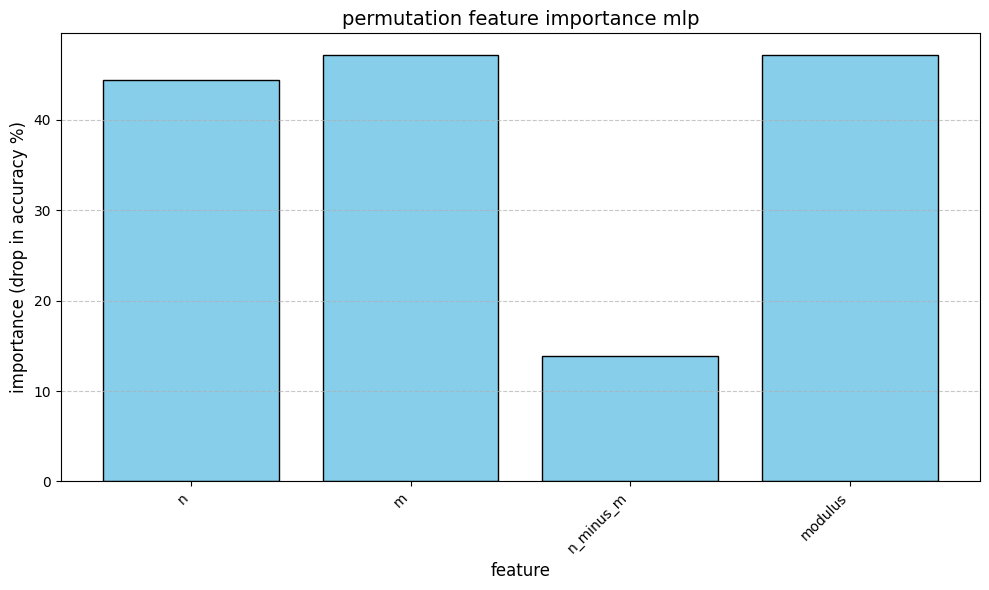

In [ ]:
# class balance report (permutation instance)
def get_accuracy(x_data, y_data):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    x_data = x_data.to(device)
    y_data = y_data.to(device)
    outputs = model(x_data)
    predicted = torch.round(torch.sigmoid(outputs))
    total = y_data.size(0)
    correct = (predicted == y_data).sum().item()
  return 100 * correct / total

# getting baseline accuracy
baseline_accuracy = get_accuracy(x_test_tensor, y_test_tensor)
print(f"baseline accuracy (unshuffled): {baseline_accuracy: .2f} %")
print('-' * 30)

feature_names = ['n', 'm', 'n_minus_m', 'modulus']
importances = []

for i in range(x_test_tensor.shape[1]):
  print(f"testing importance od: {feature_names[i]}")
  x_test_shuffled = x_test_tensor.clone()

  # shuffle only column 'i'
  perm_indices = torch.randperm(x_test_shuffled.size(0))
  x_test_shuffled[:, i] = x_test_shuffled[perm_indices, i]

  shuffled_accuracy = get_accuracy(x_test_shuffled, y_test_tensor)
  print(f"accuracy after shuffling: {shuffled_accuracy: .2f}")

  importance = baseline_accuracy - shuffled_accuracy
  importances.append(importance)
  print(f"importance (accuracy drop): {importance: .2f}")

print('feature importance plot')
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances, color='skyblue', edgecolor='black')
plt.xlabel('feature', fontsize=12)
plt.ylabel('importance (drop in accuracy %)', fontsize=12)
plt.title('permutation feature importance mlp', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('mlp_feature_importance.png')




confusion matrix:
[[36  0]
 [ 0 36]]


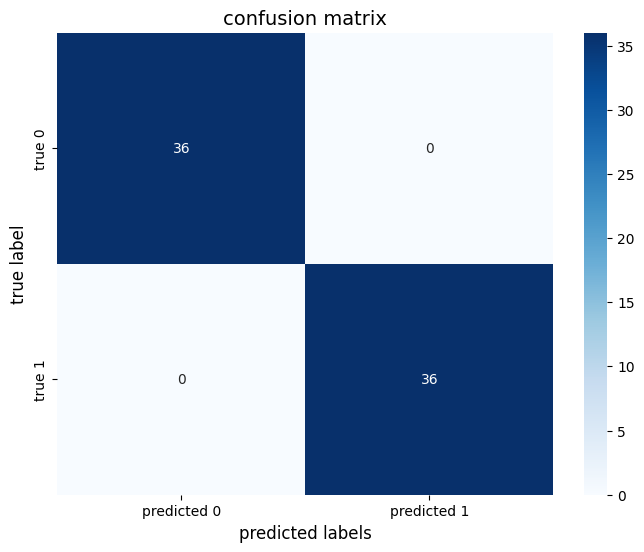

In [ ]:
# creating a 2 x 2 (confusion matrix)

model.eval()
with torch.no_grad():
  # getting predictions for the entire test set
  all_outputs = model(x_test_tensor.to(device))
  all_preds_rounded = torch.round(torch.sigmoid(all_outputs))

  # move tensors to cpu
  y_pred = all_preds_rounded.cpu().numpy().ravel()
  y_true = y_test_tensor.cpu().numpy().ravel()

# creating a confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("confusion matrix:")
print(cm)

# plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['predicted 0', 'predicted 1'],
            yticklabels=['true 0', 'true 1'])

plt.xlabel('predicted labels', fontsize=12)
plt.ylabel('true label', fontsize=12)
plt.title('confusion matrix', fontsize=14)
plt.savefig('confusion_matrix.png')
